In [7]:
pip install openpyxl

  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# 设置全局绘图风格
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决部分系统中文显示
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 环境定义 (生理模拟器 & 统一裁判)
# ==========================================
class VancoEnv:
    def __init__(self, file_path):
        print(f"--- 1. 正在初始化环境裁判 (读取: {file_path}) ---")
        try:
            df = pd.read_excel(file_path).fillna(0)
        except Exception as e:
            print(f"❌ 读取 Excel 失败，请确保安装了 openpyxl: pip install openpyxl\n错误信息: {e}")
            raise

        self.state_cols = ['vanco_level(ug/mL)', 'creatinine(mg/dL)', 'wbc(K/uL)', 
                          'bun(mg/dL)', 'temperature', 'sbp', 'heart_rate']
        self.action_col = 'totalamount_mg'
        
        X, Y_s, Y_r = [], [], []
        print("正在转换数据序列...")
        for _, group in df.groupby('stay_id'):
            group = group.sort_values('step_4hr')
            states = group[self.state_cols].values
            actions = group[self.action_col].values
            rewards = group['step_reward'].values
            for i in range(len(group) - 1):
                X.append(np.append(states[i], actions[i]))
                Y_s.append(states[i+1])
                Y_r.append(rewards[i])
        
        print(f"正在训练裁判模型 (样本量: {len(X)})...")
        self.trans_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=30, random_state=42)).fit(X, Y_s)
        self.reward_model = RandomForestRegressor(n_estimators=30, random_state=42).fit(X, Y_r)
        
        # 初始病人状态集
        self.test_patients = df.sort_values(['stay_id', 'step_4hr']).groupby('stay_id').first()[self.state_cols].values
        print(f"✅ 环境准备完毕！测试病人数: {len(self.test_patients)}")

    def get_eval_q(self, state, action):
        """核心：由裁判统一计算当前动作的价值 (Q)"""
        input_data = np.append(state, action).reshape(1, -1)
        return self.reward_model.predict(input_data)[0]

    def step(self, state, action):
        input_data = np.append(state, action).reshape(1, -1)
        next_state = self.trans_model.predict(input_data)[0]
        reward = self.reward_model.predict(input_data)[0]
        return next_state, reward

In [2]:
# ==========================================
# 2. 策略定义区 (在这里填入同学的代码)
# ==========================================

# --- [同学 1 的模型结构] ---
class ClassmateModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: 替换为同学1的实际结构
        self.net = nn.Sequential(nn.Linear(7, 64), nn.ReLU(), nn.Linear(64, 1))
    def forward(self, x): return self.net(x)

# --- [同学 2 的模型结构] ---
class ClassmateModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: 替换为同学2的实际结构
        self.net = nn.Sequential(nn.Linear(7, 128), nn.ReLU(), nn.Linear(128, 1))
    def forward(self, x): return self.net(x)

# --- [同学 3 的模型结构] ---
class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 32), nn.ReLU(), 
            nn.Linear(32, 32), nn.ReLU(), 
            nn.Linear(32, 1)
        )
    def forward(self, s, a): 
        x = torch.cat([s, a], dim=-1)
        return self.net(x)

class VNetwork(nn.Module):
    def __init__(self, state_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 32), nn.ReLU(), 
            nn.Linear(32, 32), nn.ReLU(), 
            nn.Linear(32, 1)
        )
    def forward(self, s): return self.net(s)

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim: int, action_dim: int = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 32), nn.ReLU(), 
            nn.Linear(32, 32), nn.ReLU(), 
            nn.Linear(32, action_dim * 2)
        )
    def forward(self, s): 
        out = self.net(s)
        mean, logstd = out.chunk(2, dim=-1)
        return mean, logstd.clamp(-20, 2).exp()

# 通用策略适配器
# 通用策略适配器
class StudentPolicy:
    def __init__(self, model_class, pth_path, name, state_dim=7):
        self.name = name
        self.model = model_class(state_dim=state_dim)
        
        if os.path.exists(pth_path):
            checkpoint = torch.load(pth_path, map_location='cpu')
            
            # 1. 提取策略网络字典
            if isinstance(checkpoint, dict) and 'policy_network' in checkpoint:
                state_dict = checkpoint['policy_network']
            else:
                state_dict = checkpoint

            # 2. 【核心修复】修复 Key 的前缀不匹配问题
            # 报错显示文件里多了个 "net."，我们要把它去掉
            new_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith("net."):
                    new_state_dict[k[4:]] = v  # 去掉前 4 个字符 "net."
                else:
                    new_state_dict[k] = v
            
            # 3. 加载修改后的权重
            try:
                self.model.load_state_dict(new_state_dict)
                print(f"✅ Successfully loaded {name} (Fixed prefix issue)")
            except Exception as e:
                print(f"❌ Load failed: {e}")
                # 如果还是不行，打印一下文件里的 key 方便排查
                print(f"File keys example: {list(state_dict.keys())[:3]}")
        else:
            print(f"⚠️ {pth_path} not found.")
            
        self.model.eval()

    def predict(self, state):
        state_tensor = torch.FloatTensor(state).reshape(1, -1)
        with torch.no_grad():
            mean, std = self.model(state_tensor)
            action = mean.item()
        print(f"DEBUG - State[0]: {state[0]:.2f}, Model Action Output: {action:.2f}")
        return np.clip(action, 0, 1000)

class RandomPolicy:
    def __init__(self, name="随机基准"): self.name = name
    def predict(self, state): return np.random.uniform(0, 750)

In [3]:
def plot_policy_response(env, policies):
    # 模拟一个标准病人的状态 (取所有病人的平均值)
    base_state = np.mean(env.test_patients, axis=0)
    
    # 构建万古霉素浓度序列 0 - 50
    vanco_range = np.linspace(0, 50, 100)
    
    plt.figure(figsize=(12, 6))
    
    for pol in policies:
        doses = []
        for v in vanco_range:
            test_s = base_state.copy()
            test_s[0] = v  # 替换第一列：万古霉素浓度
            doses.append(pol.predict(test_s))
        
        plt.plot(vanco_range, doses, label=pol.name, lw=3)

    # 绘制医学逻辑参考线
    plt.axvspan(15, 20, color='green', alpha=0.1, label='Target Window (15-20)')
    plt.title("Dose-Response Curve: How Policy Reacts to Concentration", fontsize=16)
    plt.xlabel("Current Vanco Concentration (ug/mL)", fontsize=14)
    plt.ylabel("Output Dosage (mg)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 在 if __name__ == "__main__": 中调用
# plot_policy_response(env, test_policies)

--- 1. 正在初始化环境裁判 (读取: ready_data.xlsx) ---
正在转换数据序列...
正在训练裁判模型 (样本量: 2055)...
✅ 环境准备完毕！测试病人数: 58
✅ Successfully loaded IQL (Fixed prefix issue)
🚀 正在深度评估: Random Baseline...
🚀 正在深度评估: IQL...
DEBUG - State[0]: 0.00, Model Action Output: 383.07
DEBUG - State[0]: 9.89, Model Action Output: 409.42
DEBUG - State[0]: 7.84, Model Action Output: 398.75
DEBUG - State[0]: 6.59, Model Action Output: 387.06
DEBUG - State[0]: 8.00, Model Action Output: 395.19
DEBUG - State[0]: 7.22, Model Action Output: 387.13
DEBUG - State[0]: 6.89, Model Action Output: 390.21
DEBUG - State[0]: 6.59, Model Action Output: 392.01
DEBUG - State[0]: 7.60, Model Action Output: 387.38
DEBUG - State[0]: 7.39, Model Action Output: 393.94
DEBUG - State[0]: 7.24, Model Action Output: 388.53
DEBUG - State[0]: 6.89, Model Action Output: 394.35
DEBUG - State[0]: 6.42, Model Action Output: 383.97
DEBUG - State[0]: 5.30, Model Action Output: 388.31
DEBUG - State[0]: 4.71, Model Action Output: 381.86
DEBUG - State[0]: 0.00, Model

DEBUG - State[0]: 6.60, Model Action Output: 489.64
DEBUG - State[0]: 6.93, Model Action Output: 490.45
DEBUG - State[0]: 6.39, Model Action Output: 488.29
DEBUG - State[0]: 6.77, Model Action Output: 491.02
DEBUG - State[0]: 6.29, Model Action Output: 487.30
DEBUG - State[0]: 6.69, Model Action Output: 490.18
DEBUG - State[0]: 0.00, Model Action Output: 383.50
DEBUG - State[0]: 0.62, Model Action Output: 391.02
DEBUG - State[0]: 0.47, Model Action Output: 384.22
DEBUG - State[0]: 0.35, Model Action Output: 385.43
DEBUG - State[0]: 0.26, Model Action Output: 379.42
DEBUG - State[0]: 0.21, Model Action Output: 383.80
DEBUG - State[0]: 0.17, Model Action Output: 380.70
DEBUG - State[0]: 0.12, Model Action Output: 384.62
DEBUG - State[0]: 0.09, Model Action Output: 386.75
DEBUG - State[0]: 0.06, Model Action Output: 382.02
DEBUG - State[0]: 0.05, Model Action Output: 389.30
DEBUG - State[0]: 0.03, Model Action Output: 383.46
DEBUG - State[0]: 0.02, Model Action Output: 383.05
DEBUG - Stat

DEBUG - State[0]: 5.59, Model Action Output: 379.96
DEBUG - State[0]: 4.98, Model Action Output: 375.51
DEBUG - State[0]: 5.14, Model Action Output: 378.60
DEBUG - State[0]: 5.28, Model Action Output: 375.52
DEBUG - State[0]: 5.05, Model Action Output: 378.75
DEBUG - State[0]: 0.00, Model Action Output: 394.27
DEBUG - State[0]: 0.00, Model Action Output: 352.19
DEBUG - State[0]: 0.00, Model Action Output: 354.02
DEBUG - State[0]: 0.00, Model Action Output: 358.15
DEBUG - State[0]: 0.28, Model Action Output: 361.13
DEBUG - State[0]: 0.24, Model Action Output: 359.54
DEBUG - State[0]: 0.18, Model Action Output: 352.66
DEBUG - State[0]: 0.65, Model Action Output: 356.90
DEBUG - State[0]: 0.79, Model Action Output: 353.44
DEBUG - State[0]: 0.90, Model Action Output: 355.80
DEBUG - State[0]: 0.75, Model Action Output: 354.62
DEBUG - State[0]: 0.86, Model Action Output: 357.61
DEBUG - State[0]: 0.94, Model Action Output: 352.74
DEBUG - State[0]: 1.04, Model Action Output: 353.93
DEBUG - Stat

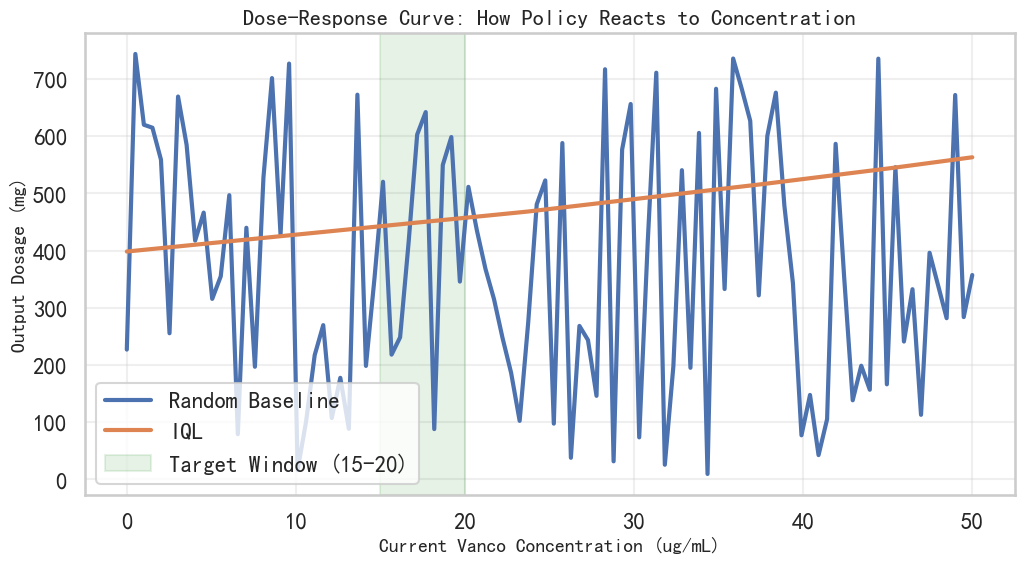

C:\Windows\Temp\ipykernel_9928\3694984744.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Policy', y='Total_Reward', data=df_summary, palette="Set2", ax=ax1)
C:\Windows\Temp\ipykernel_9928\3694984744.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Policy', y='Expected_Reward', data=df_summary, ax=ax2, palette="viridis")
C:\Windows\Temp\ipykernel_9928\3694984744.py:91: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_steps.pivot_table(


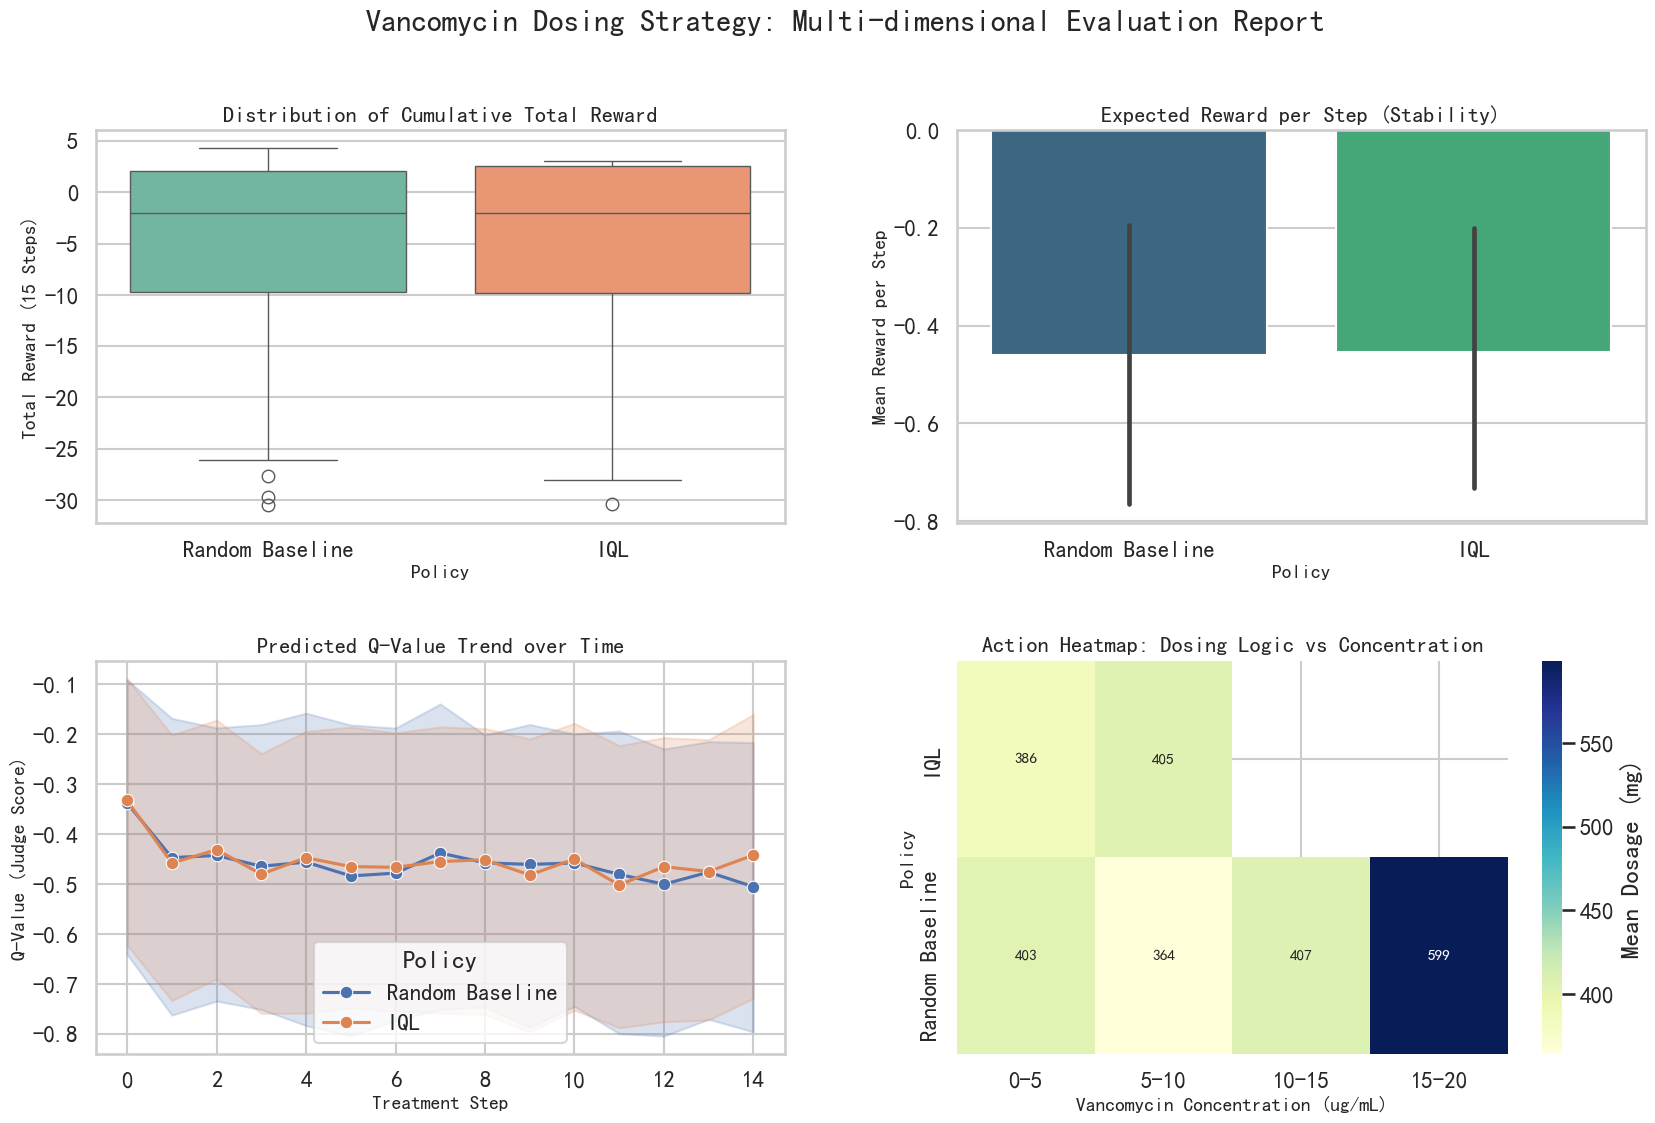

In [4]:
# ==========================================
# 3. 运行评估与绘图
# ==========================================
def run_evaluation(env, policies, n_patients=30):
    step_results = []
    summary_results = []

    for pol in policies:
        print(f"🚀 正在深度评估: {pol.name}...")
        for p_idx in range(min(n_patients, len(env.test_patients))):
            s = env.test_patients[p_idx]
            total_r = 0
            steps_limit = 15
            
            for t in range(steps_limit):
                a = pol.predict(s)
                q = env.get_eval_q(s, a)
                next_s, r = env.step(s, a)
                
                # 记录数据：直接存入字典
                step_results.append({
                    'Policy': pol.name,
                    'Step': t,
                    'Q_Value': q,
                    'Reward': r,
                    'Dose': a,
                    'Vanco_Conc': s[0], # 使用统一内部名 'Vanco_Conc'
                    'Patient': p_idx
                })
                total_r += r
                s = next_s
            
            summary_results.append({
                'Policy': pol.name,
                'Total_Reward': total_r,
                'Expected_Reward': total_r / steps_limit,
                'Patient': p_idx
            })

    return pd.DataFrame(step_results), pd.DataFrame(summary_results)

if __name__ == "__main__":
    DATA_FILE = 'ready_data.xlsx'
    
    if os.path.exists(DATA_FILE):
        env = VancoEnv(DATA_FILE)
        
        # Assemble policies (Uncomment your classmates' models as needed)
        test_policies = [
            RandomPolicy(name="Random Baseline"),
            StudentPolicy(GaussianPolicy, 'iql_model.pth', "IQL"),
            # StudentPolicy(ClassmateModel_2, 'student2.pth', "CQL (Classmate 2)"),
        ]
        
        # Run Evaluation
        df_steps, df_summary = run_evaluation(env, test_policies)
        plot_policy_response(env, test_policies)
        # --- Data Preprocessing for Heatmap ---
        bins = [-np.inf, 5, 10, 15, 20, 25, 30, 35, np.inf]
        labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
        df_steps['Vanco_Range'] = pd.cut(df_steps['Vanco_Conc'], bins=bins, labels=labels)

        # --- Plotting Dashboard ---
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.25)

        # 1. Total Reward (Boxplot)
        ax1 = fig.add_subplot(gs[0, 0])
        sns.boxplot(x='Policy', y='Total_Reward', data=df_summary, palette="Set2", ax=ax1)
        ax1.set_title("Distribution of Cumulative Total Reward", fontsize=16)
        ax1.set_xlabel("Policy", fontsize=14)
        ax1.set_ylabel("Total Reward (15 Steps)", fontsize=14)

        # 2. Expected Reward (Barplot)
        ax2 = fig.add_subplot(gs[0, 1])
        sns.barplot(x='Policy', y='Expected_Reward', data=df_summary, ax=ax2, palette="viridis")
        ax2.set_title("Expected Reward per Step (Stability)", fontsize=16)
        ax2.set_xlabel("Policy", fontsize=14)
        ax2.set_ylabel("Mean Reward per Step", fontsize=14)

        # 3. Q-Value Trend (Lineplot)
        ax3 = fig.add_subplot(gs[1, 0])
        sns.lineplot(x='Step', y='Q_Value', hue='Policy', data=df_steps, ax=ax3, marker='o')
        ax3.set_title("Predicted Q-Value Trend over Time", fontsize=16)
        ax3.set_xlabel("Treatment Step", fontsize=14)
        ax3.set_ylabel("Q-Value (Judge Score)", fontsize=14)
        ax3.legend(title="Policy", loc='best')

        # 4. Action Heatmap (Heatmap)
        ax4 = fig.add_subplot(gs[1, 1])
        heatmap_data = df_steps.pivot_table(
            index='Policy', 
            columns='Vanco_Range', 
            values='Dose', 
            aggfunc='mean'
        )
        sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax4, 
                    cbar_kws={'label': 'Mean Dosage (mg)'}, annot_kws={"size": 11})
        ax4.set_title("Action Heatmap: Dosing Logic vs Concentration", fontsize=16)
        ax4.set_xlabel("Vancomycin Concentration (ug/mL)", fontsize=14)
        ax4.set_ylabel("Policy", fontsize=14)

        # Main Title
        plt.suptitle("Vancomycin Dosing Strategy: Multi-dimensional Evaluation Report", fontsize=22, y=0.98)
        
        # Save or Show
        # plt.savefig('evaluation_report.png', dpi=300)
        plt.show()
    else:
        print(f"❌ Error: {DATA_FILE} not found.")